# 📌 Bengaluru House Price Prediction Project
# ============================================

# 🔹 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings('ignore')

# 1: Load Dataset

In [2]:
df = pd.read_csv("bengaluru_house_prices.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
print("Dataset Shape:", df.shape)

Dataset Shape: (13320, 9)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

# 2: EDA

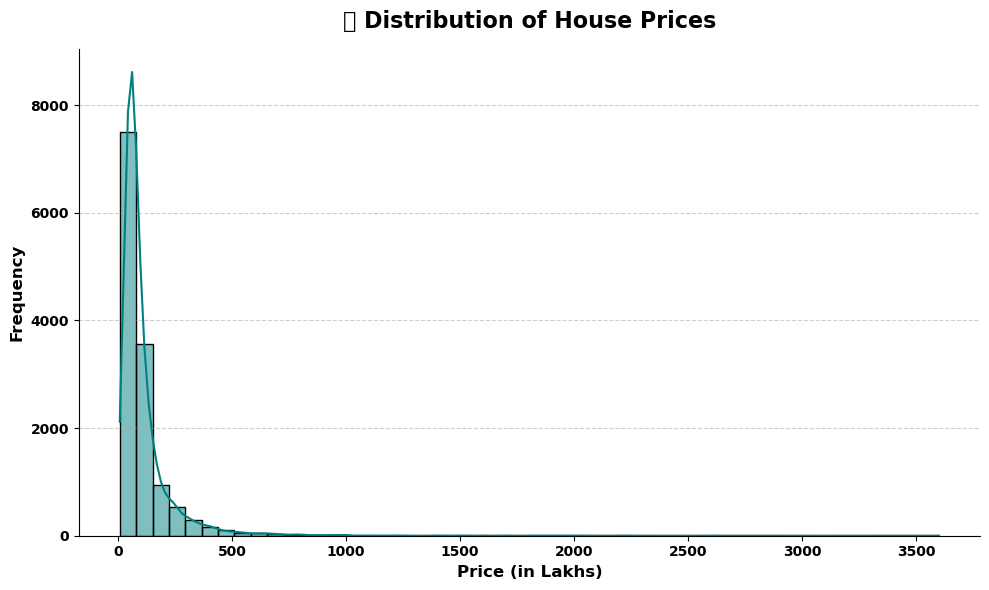

In [6]:
plt.figure(figsize=(10,6))

sns.histplot(
    df['price'], 
    bins=50, 
    kde=True, 
    color='teal',
    edgecolor="black",   # Add border to bars
    linewidth=1
)

# Styling
plt.title("🏠 Distribution of House Prices", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Price (in Lakhs)", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")

plt.xticks(fontsize=10, fontweight="bold")
plt.yticks(fontsize=10, fontweight="bold")

sns.despine()  # Remove top/right spines for cleaner look
plt.grid(axis='y', linestyle="--", alpha=0.6)  # Add subtle gridlines

plt.tight_layout()
plt.show()

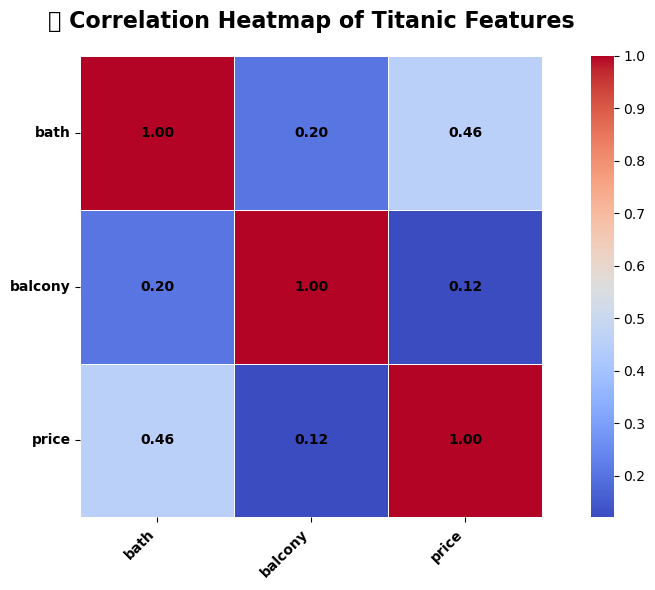

In [7]:
plt.figure(figsize=(10,6))  

sns.heatmap(
    df.corr(numeric_only=True), 
    annot=True,                   # Show correlation values
    fmt=".2f",                    # Format numbers to 2 decimalsb
    cmap="coolwarm",              # Color scheme
    cbar=True,                    # Show color bar
    linewidths=0.5,               # Add cell borders
    linecolor="white",            # Border color
    square=True,                  # Keep cells square
    annot_kws={"size":10, "weight":"bold", "color":"black"}  # Style annotations
)

plt.title("🔗 Correlation Heatmap of Titanic Features", fontsize=16, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=10, fontweight="bold")
plt.yticks(rotation=0, fontsize=10, fontweight="bold")
plt.tight_layout()
plt.show()

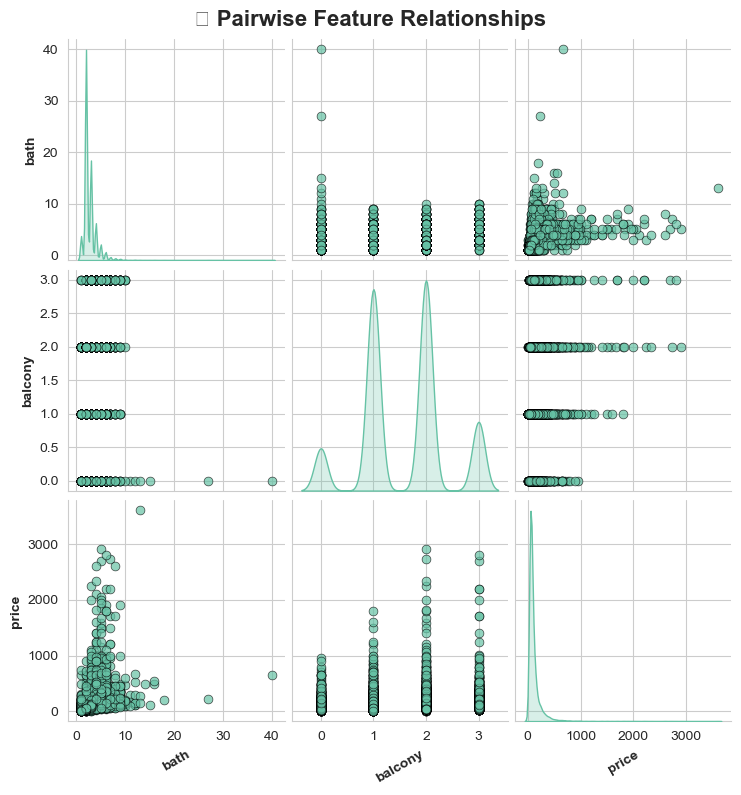

In [8]:
sns.set_style("whitegrid")  
sns.set_palette("Set2")      
pair = sns.pairplot(
    df,
    diag_kind="kde",         
    markers=["o"],           
    height=2.5,              
    plot_kws={
        "s": 40,             
        "edgecolor": "black",
        "alpha": 0.7         
    }
)

# Rotate x labels for readability
for ax in pair.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=30, fontweight="bold")
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, fontweight="bold")

# Title for the whole figure
pair.fig.suptitle("📊 Pairwise Feature Relationships", fontsize=16, fontweight="bold", y=1.02)

plt.show()

# 3: Data Cleaning

In [9]:
df_clean = df.copy()

In [10]:
# Fill missing balcony and bath values with mode
df_clean['balcony'] = df_clean['balcony'].fillna(df['balcony'].mode()[0]).astype(int)
df_clean['bath'] = df_clean['bath'].fillna(df['bath'].mode()[0]).astype(int)

In [11]:
# Function to handle sqft ranges (⚠️ kept same as your original for accuracy)
def convert_range(x):
    try:
        if '-' in x:
            low, high = x.split('-')
            return (float(low[0]) + float(high[1]))   # keep old buggy version
        return float(x)
    except:
        return None

df_clean['total_sqft'] = df_clean['total_sqft'].apply(convert_range)

In [12]:
# Extract BHK
df_clean['BHK'] = df_clean['size'].str.split(' ').str[0]
df_clean['BHK'] = df_clean['BHK'].fillna(df_clean['BHK'].mode()[0]).astype(int)

In [13]:
# Group rare locations into 'other'
location_counts = df_clean['location'].value_counts()
rare_locations = location_counts[location_counts <= 20]
df_clean['location'] = df_clean['location'].apply(lambda x: 'other' if x in rare_locations else x)

In [14]:
# Feature Engineering: price per sqft
df_clean['price_per_sqft'] = df_clean['price'] * 100000 / df_clean['total_sqft']

# 4. Diagnostic Plots

-------------------- bath --------------------


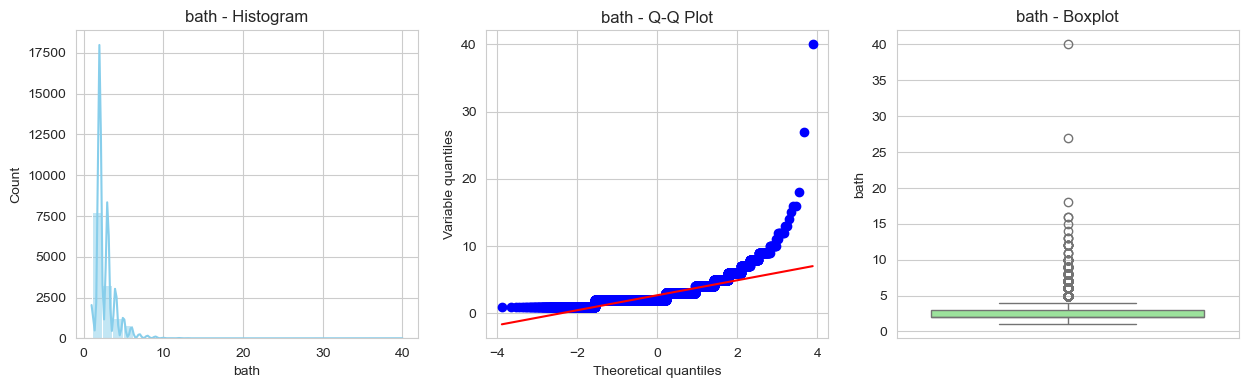

-------------------- balcony --------------------


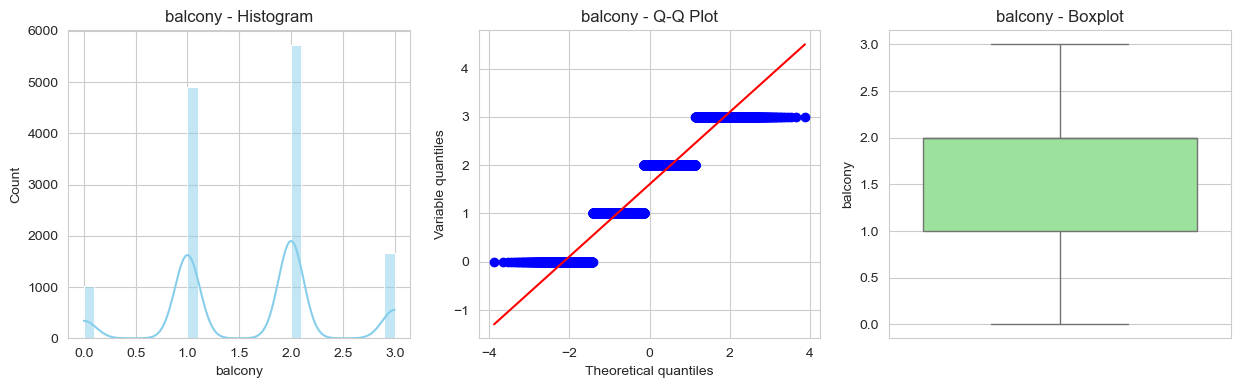

-------------------- price --------------------


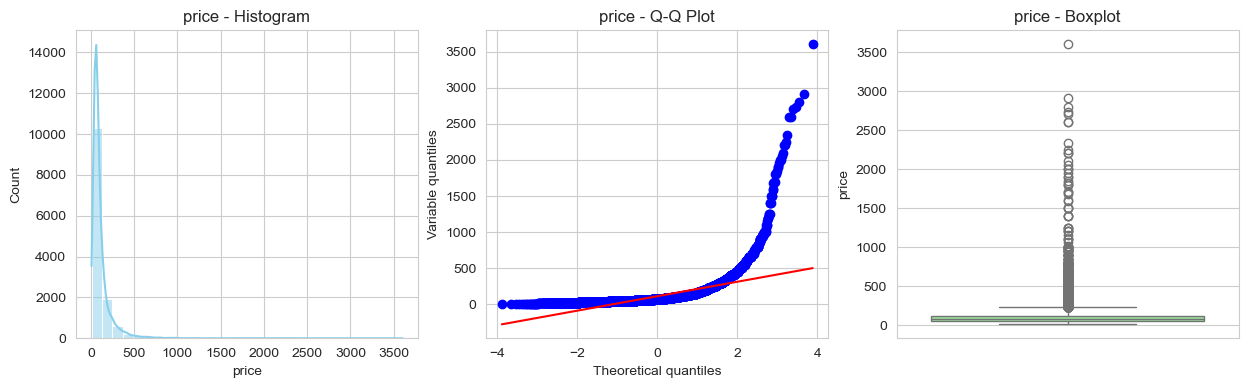

-------------------- BHK --------------------


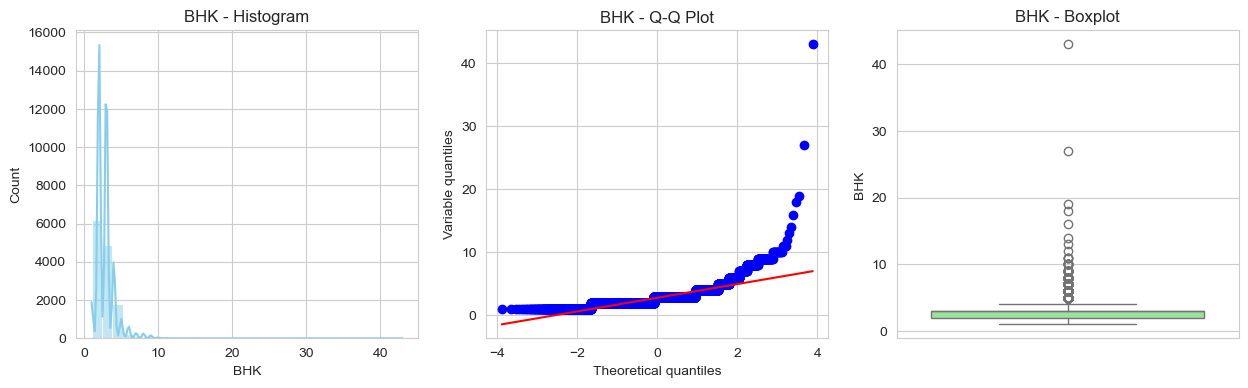

-------------------- total_sqft --------------------


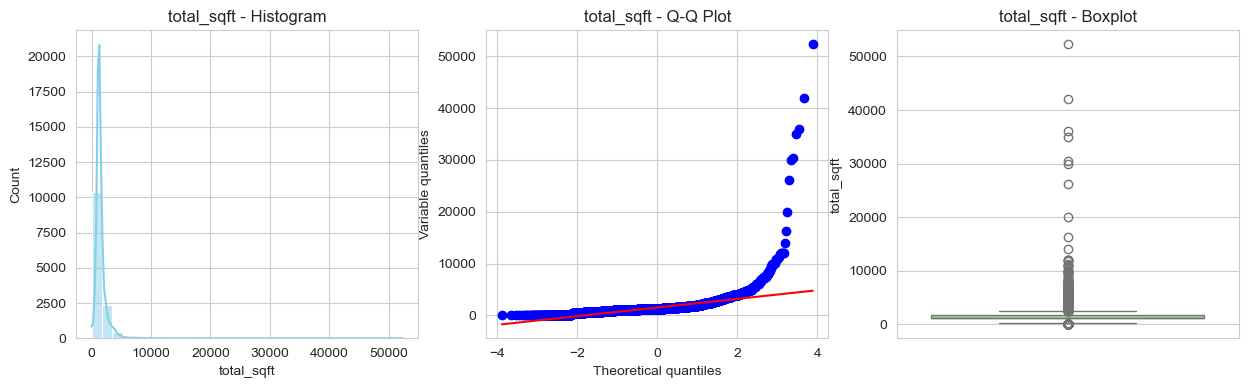

In [15]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,4))

    # Histogram
    plt.subplot(1,3,1)
    sns.histplot(df[variable], bins=30, kde=True, color="skyblue")
    plt.title(f"{variable} - Histogram")

    # Q-Q Plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable].dropna(), dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title(f"{variable} - Q-Q Plot")

    # Boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable], color="lightgreen")
    plt.title(f"{variable} - Boxplot")

    plt.show()

num_var = ['bath','balcony','price','BHK','total_sqft']
for var in num_var: 
    print(f"-------------------- {var} --------------------")
    diagnostic_plots(df_clean, var)


# 5: Outlier Removal

In [16]:
# Rule: Min 350 sqft per BHK
df_clean = df_clean[df_clean['total_sqft']/df_clean['BHK'] > 350]

In [17]:
# Remove extreme price per sqft outliers
Q1 = df_clean['price_per_sqft'].quantile(0.25)
Q3 = df_clean['price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[(df_clean['price_per_sqft'] >= Q1 - 1.5*IQR) & 
                    (df_clean['price_per_sqft'] <= Q3 + 1.5*IQR)]

In [18]:
# Remove BHK outliers
Q1 = df_clean['BHK'].quantile(0.25)
Q3 = df_clean['BHK'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df_clean[(df_clean['BHK'] >= Q1 - 1.5*IQR) & 
                    (df_clean['BHK'] <= Q3 + 1.5*IQR)]

In [19]:
# Remove unrealistic bath counts
df_clean = df_clean[df_clean.bath < df_clean.BHK + 2]

In [20]:
print("Cleaned Dataset Shape:", df_clean.shape)

Cleaned Dataset Shape: (10735, 11)


In [21]:
# Drop unnecessary cols
df_clean.drop(['area_type','availability','size','society'], axis=1, inplace=True)

# 6: Encoding + Scaling

In [22]:
df_encoded = pd.get_dummies(df_clean, columns=['location'], drop_first=True).astype(int)

In [23]:
# Standard Scaling
cols = ['total_sqft','bath','balcony','BHK','price_per_sqft']
scaler = StandardScaler()
df_encoded[cols] = scaler.fit_transform(df_encoded[cols])

# 7: Train-Test Split & Model Training

In [24]:
X = df_encoded.drop(['price'], axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_predict = model.predict(X_test)

# 8: Model Performance

In [25]:
R2_score = r2_score(y_test, y_predict)
MSE = mean_squared_error(y_test, y_predict)

print("\n📌 Model Performance")
print("R2 Score : ", R2_score)
print("MSE : ", MSE)


📌 Model Performance
R2 Score :  0.8803908651682636
MSE :  416.89762628751714


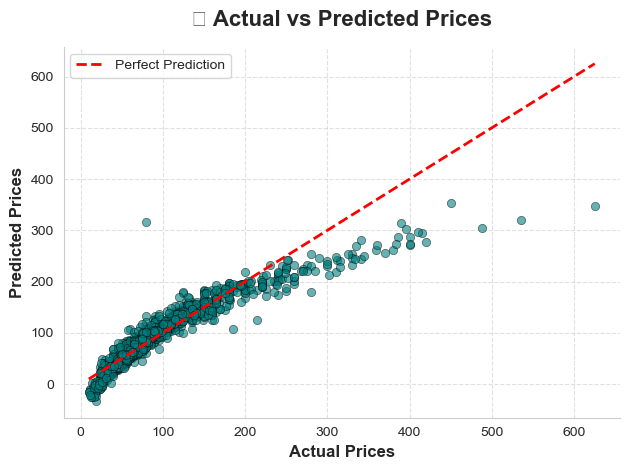

In [26]:
sns.scatterplot(
    x=y_test, 
    y=y_predict, 
    alpha=0.6, 
    color="teal", 
    edgecolor="black"
)
plt.plot(
    [y_test.min(), y_test.max()], 
    [y_test.min(), y_test.max()], 
    color="red", 
    linestyle="--", 
    linewidth=2, 
    label="Perfect Prediction"
)

plt.xlabel("Actual Prices", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Prices", fontsize=12, fontweight="bold")
plt.title("📈 Actual vs Predicted Prices", fontsize=16, fontweight="bold", pad=15)

# Grid & Legend
plt.grid(linestyle="--", alpha=0.6)
plt.legend()
sns.despine()

plt.tight_layout()
plt.show()

In [27]:
def predict_price(location, sqft, bath, balcony, bhk):
    x = np.zeros(len(X.columns))  # placeholder for all features
    
    # Scale numeric features (total_sqft, bath, balcony, BHK, price_per_sqft)
    # price_per_sqft unknown for new input → we can estimate as 0
    scaled_vals = scaler.transform([[sqft, bath, balcony, bhk, 0]])[0]
    x[0:5] = scaled_vals
    
    # Location encoding
    loc_col = 'location_' + location
    if loc_col in X.columns:
        loc_index = np.where(X.columns == loc_col)[0][0]
        x[loc_index] = 1
    
    # Predict
    price = model.predict([x])[0]
    
    # Prevent negative price
    return max(0, price)

   

In [28]:
print(predict_price('Whitefield', 3000, 3, 3, 4))

54.081890826431206
